## 理论
数学推导请参考《统计机器学习》-李航

GBRT是对任意的可微损失函数的提升算法的泛化，即可回归亦可分（sai）类（ting）。
优点：
 1. 对混合数据的的天然处理能力
 2. 强大的预测能力（主要指算法本身的能力强大，一般性能好）
 3. 在输出空间中对异常点的鲁棒性（通过具有鲁棒性的损失函数来实现的）
缺点：
 1. 难以并行计算
 
## Sklearn note：
查过两类的分类问题需要在每一次迭代的推导n-classes个回归树。因此所有需要推导的树的数量等于`n-classses * nesstimators`.所以在数据量较大的时候建议使用其他算法代替GBRT.

下面例子,我们依旧使用Adaboost算法特性中的数据,同时先下面的例子也很好的证明了两个结论:

 1. 子采样可以有效的避免过拟合
 2. 子采样也会导致偏差增加,因此相比于原来的Adaboost需要更多的提升次数. (关于如何更好地使用梯度提升算法,请看倒数第二部分)

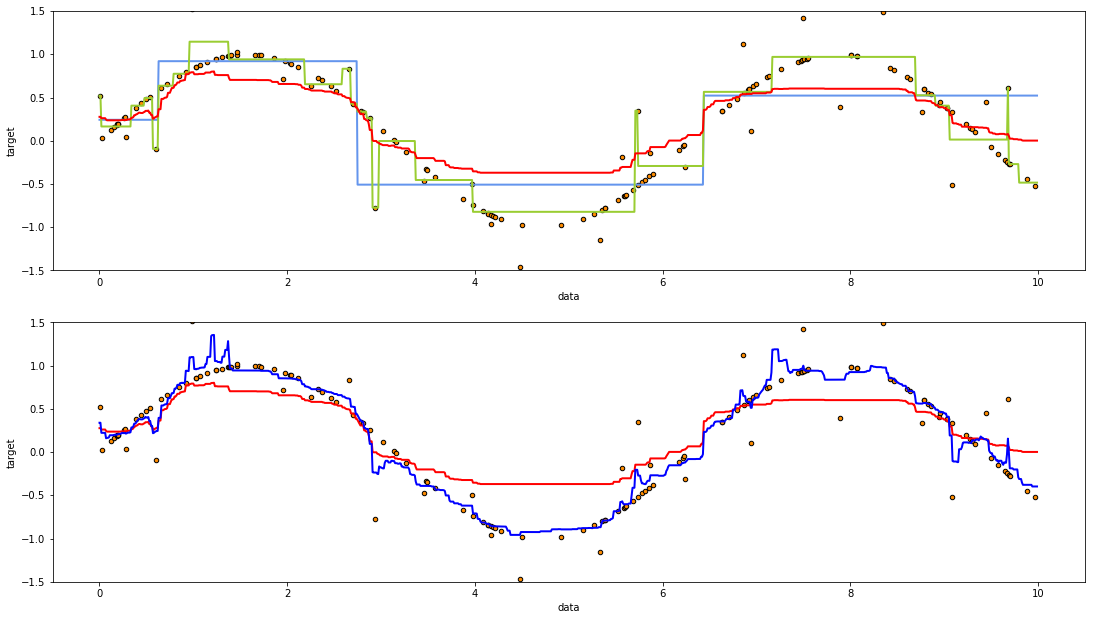

In [26]:
%matplotlib inline
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(10 * rng.rand(160, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 2 * (0.5 - rng.rand(int(len(X)/5))) # 每五个点增加一次噪音

# Fit regression model
               
estimators_num = 500

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
params_1 = {'n_estimators': 100, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}

params_2 = {'n_estimators': 500, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
regr_3 = GradientBoostingRegressor(**params_1)
regr_4 = GradientBoostingRegressor(**params_2)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
regr_4.fit(X, y)

# Predict
X_test = np.arange(0.0, 10.0, 0.01)[:, np.newaxis]
y_test = np.sin(X_test).ravel()
y_test[::5] += 2 * (0.5 - rng.rand(int(len(X_test)/5))) # 每五个点增加一次噪音
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)
y_4 = regr_4.predict(X_test)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(2, 1, 1)
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
ax.plot(X_test, y_1, color="cornflowerblue",label="max_depth=2", linewidth=2)
ax.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
ax.plot(X_test, y_3, color="r", label="n_estimators=100", linewidth=2)
ax.set_xlabel("data")
ax.set_ylabel("target")
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(-0.5, 10.5)


ax = fig.add_subplot(2, 1, 2)
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
ax.plot(X_test, y_3, color="r", label="n_estimators=10", linewidth=2)
ax.plot(X_test, y_4, color="blue", label="n_estimators=1000", linewidth=2)
ax.set_xlabel("data")
ax.set_ylabel("target")
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(-0.5, 10.5)

plt.show()

## 特征重要程度相对排名

此处效果类似于之前写过的[RF](http://blog.csdn.net/fontthrone/article/details/79074154)奔出不再做过多解释.

## 散列映射
 1. 获取新的特征
 2. 对样本进行高纬度,稀疏编码
 
类似效果参考[RF](http://blog.csdn.net/fontthrone/article/details/79074154),但是要注意的是一般而言,提升算法系列创建新特征的效果一般优于RF,比如XGBoost,LightGBM等,具体使用上也有一定的策略,这方面你可以先参考[Bryan大佬的博客](http://blog.csdn.net/bryan__/article/details/51769118),不过我之后也会写类似的总结,你也可以参考我的文章.

## 使用Out-of-bagging进行泛化能力的评估
这种泛化评估方式之前也提到过,有一定的效果,作用类似于CV与holdout,性能应该还可以,但是我没真正在比赛中使用过这个,或者进行有一定数量和质量的数据集测试,这里先挖个坑,也是以后再填.

下面的[例子](http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_oob.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-oob-py)是对三种泛化能力评估方式的比较,可以看出相比之下

Accuracy: 0.6840


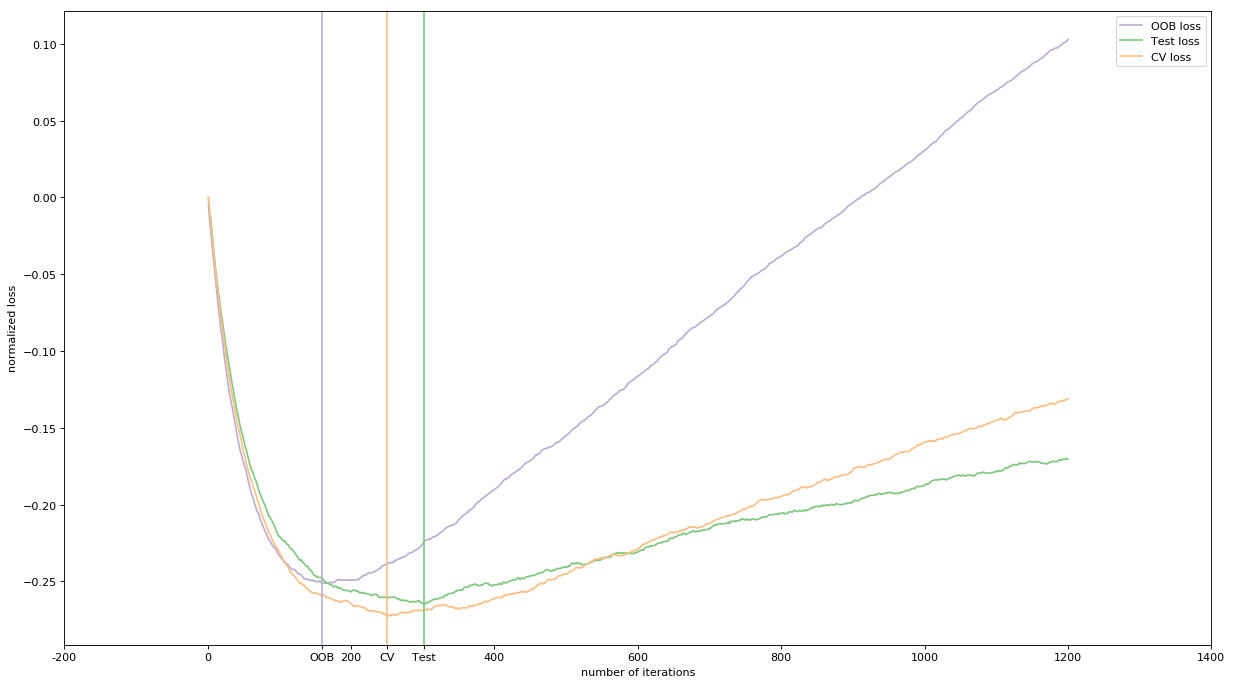

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


# Generate data (adapted from G. Ridgeway's gbm example)
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

p = 1 / (1.0 + np.exp(-(np.sin(3 * x1) - 4 * x2 + x3)))
y = random_state.binomial(1, p, size=n_samples)

X = np.c_[x1, x2, x3]

X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

# Fit classifier with out-of-bag estimates
params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1


def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_splits=3):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores


# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# plot curves and vertical lines for best iterations
plt.figure(figsize=(18.5,10.5),dpi=80) 
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()

## 损失函数

以下是sklearn目前支持的损失函数,具体损失函数可以通过参数 loss 指定,GBRT的鲁棒性就是依靠带有鲁棒性的损失函数实现的:

回归 (Regression)
 - Least squares ( 'ls' ): 由于其优越的计算性能,该损失函数成为回归算法中的自然选择。 损失函数的初始值 通过目标值的均值给出。
 - Least absolute deviation ( 'lad' ): 回归中具有**鲁棒性**的损失函数,损失函数的初始值 通过目标值的中值给出。
 - Huber ( 'huber' ): 回归中另一个具有**鲁棒性**的损失函数,它是最小二乘和最小绝对偏差两者的结合. 其利用 alpha 来控制模型对于异常点的敏感度(详细介绍请参考 [F2001]).
 - Quantile ( 'quantile' ): 分位数回归损失函数.用 0 < alpha < 1 来指定分位数这个损 失函数可以用来产生预测间隔。（详见 Prediction Intervals for Gradient Boosting Regression ）。
分类 (Classification)
 - Binomial deviance ('deviance'): 对于二分类问题(提供概率估计)即负的二项 log 似然损失函数。模型以 log 的比值比来初始化。
 - Multinomial deviance ('deviance'): 对于多分类问题的负的多项log似然损失函数具有 n_classes 个互斥的类。提供概率估计。 初始模型由每个类的先验概率给出.在每一次迭代中 n_classes 回归树被构建,**这使得 GBRT 在处理多类别数据集时相当低效**。
 - Exponential loss ('exponential'): 与 AdaBoostClassifier 具有相同的损失函数。与 'deviance' 相比，对被错误标记的样本的鲁棒性较差，仅用于在二分类问题。


## 正则化的问题

### 学习率
一个简单的正则化策略,通过一个因子 \nu 来衡量每个弱分类器对于最终结果的贡献:

F_m(x) = F_{m-1}(x) + \nu \gamma_m h_m(x)

参数 \nu 由于它可以控制梯度下降的步长, 因此也叫作 learning rate ，它可以通过 learning_rate 参数来设置.

一般较小的学习率可以得到更精准的结果,但是同时也需要更多的基学习器配合,通常会设置早停配合使用

## 子采样(减小方差)

梯度提升树作为提升算法的一个分支,其拟合能力确实很强,但是同样的也带来了的更多的过拟合风险.子采样则是减少过拟合(方差)问题的一个有效手段

一般而言, 
 1. 指定学习率效果比指定学习率好
 2. 子采样与学习率相结合最佳,只使用子采样而不使用学习率效果最差

## 特征子采样(进一步减小方差)

一般而言我们所说的子采样仅仅是样本上的子采样,但是假如在使用样本子采样之后过拟合带来的误差仍然占较大比例,那么我们可以使用特征子采样的方式来进一步减小方差

下面的[例子](http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regularization.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regularization-py)很好的展示了关于前面的几个参数关于最终误差的关系

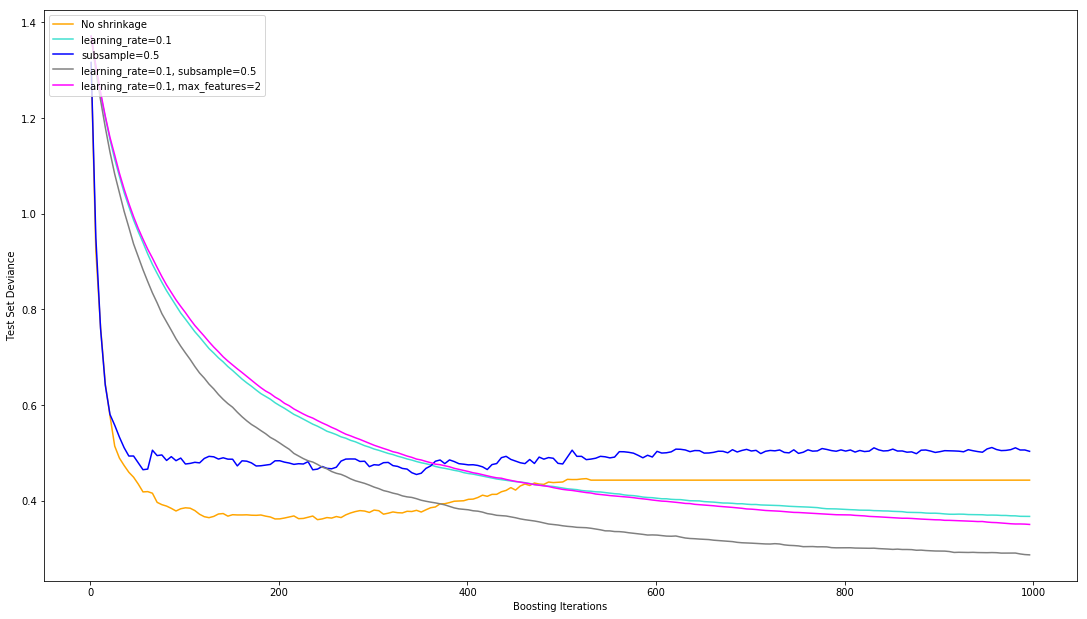

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets

X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

## 部分依赖(可用于特征工程)

部分依赖图,可以展示属性之间的线性关系,相比与皮尔逊等判断公式,这种方式能够更直接地发现同一特征不同区间与我们的y的关系.

部分依赖图（PDP）展示了目标响应和一系列目标特征的依赖关系，同时边缘化了其他所有特征值（候选特征）。 直觉上，我们可以将部分依赖解释为作为目标特征函数的预期目标响应。

由于人类感知能力的限制，目标特征的设置必须小一点(通常是1到2)，因此目标特征通常在最重要的特征中选择。

单向 PDPs 告诉我们目标响应和目标特征的相互影响(例如：线性或者非线性)。下图图中的左上图展示了一个地区的中等收入对中等房价的影响。我们可以清楚的看到两者之间是线性相关的。

具有两个目标特征的 PDPs 显示这两个特征之间的相互影响。例如：上图中两个变量的 PDP 展示了房价中位数与房屋年龄和每户平均入住人数之间的依赖关系。我们能清楚的看到这两个特征之间的影响：对于每户入住均值而言,当其值大于 2 时，房价与房屋年龄几乎是相对独立的，而其值小于 2 的时，房价对房屋年龄的依赖性就会很强。

模型 partial_dependence 提供了一个便捷的函数 plot_partial_dependence 来产生单向或双向部分依赖图。在下图的例子中我们展示如何创建一个部分依赖的网格图：特征值介于 0 和 1 的两个单向依赖 PDPs 和一个在两个特征间的双向 PDPs:

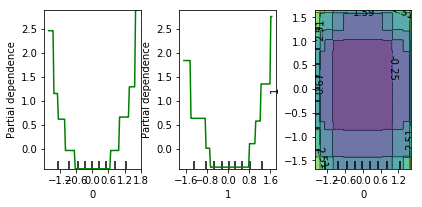

In [28]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt

X, y = make_hastie_10_2(random_state=0)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X, y)
features = [0, 1, (0, 1)]
fig, axs = plot_partial_dependence(clf, X, features)
plt.show()

In [9]:
# 如果你需要部分依赖函数的原始值而不是图，你可以调用 partial_dependence 函数:
from sklearn.ensemble.partial_dependence import partial_dependence
pdp, axes = partial_dependence(clf, [0], X=X)
pdp

array([[ 2.46643157,  2.46643157,  2.46643157,  2.46643157,  2.46643157,
         2.46643157,  1.15418258,  1.15418258,  1.15418258,  1.15418258,
         1.15418258,  0.61847569,  0.61847569,  0.61847569,  0.61847569,
         0.61847569,  0.61847569,  0.61847569,  0.61847569, -0.03524098,
        -0.03524098, -0.03524098, -0.03524098, -0.03524098, -0.03524098,
        -0.03524098, -0.03524098, -0.03524098, -0.03524098, -0.03524098,
        -0.41817365, -0.41817365, -0.41817365, -0.41817365, -0.41817365,
        -0.41817365, -0.41817365, -0.41817365, -0.41817365, -0.41817365,
        -0.41817365, -0.41817365, -0.41817365, -0.41817365, -0.41817365,
        -0.41817365, -0.41817365, -0.41817365, -0.41817365, -0.41817365,
        -0.41817365, -0.41817365, -0.41817365, -0.41817365, -0.41817365,
        -0.41817365, -0.41817365, -0.41817365, -0.41817365, -0.41817365,
        -0.41817365, -0.41817365, -0.41817365, -0.41817365, -0.41817365,
        -0.41817365, -0.41817365, -0.41817365, -0.4

该函数允许通过 grid 参数指定应该被评估的部分依赖函数的的目标特征值或可以十分便利地通过设置 X 参数从而在训练数据中自动创建 grid 。如果 X 被给出，函数返回的 axes 为每个目标特征提供轴。

对于 grid 中的每一个 ‘目标’ 特征值，部分依赖函数需要边缘化一棵树中所有候选特征的可能值的预测。 在决策树中，这个函数可以在不参考训练数据的情况下被高效的评估，对于每一网格点执行加权遍历: 如果切分点包含 ‘目标’ 特征，遍历其相关的左分支或相关的右分支,否则就遍历两个分支。每一个分支将被通过进入该分支的训练样本的占比加权， 最后，部分依赖通过所有访问的叶节点的权重的平均值给出。组合树（tree ensembles）的整体结果，需要对每棵树的结果再次平均得到。

## 参考

 - [sklearn官方文档:ensemble(集成算法)](http://scikit-learn.org/stable/modules/ensemble.html)及部分相关示例
 - [sklearn ApacheCN官方翻译(集成算法)](http://sklearn.apachecn.org/cn/0.19.0/modules/ensemble.html)
 - 李航教授——《统计机器学习》